In [0]:
# Import Libraries

import pandas as  pd
import numpy as np

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

import math
import time
from tqdm import tqdm

import os
sns.set_context("paper", rc={"axes.labelsize":50})
if os.path.isdir("model/")==False:
    os.mkdir('model')

# model settings    
epochs=50
batch_size=128

tf.set_random_seed(42)

In [0]:
# Neural network model
class nn_model():
    def __init__(self):
        with tf.Graph().as_default():
            self.x=tf.placeholder(tf.float32,shape=[None,784])
            self.labels=tf.placeholder(tf.int32,shape=[None])
            
            # creating neural network
            self.layer1=tf.layers.dense(self.x,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer2=tf.layers.dense(self.layer1,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer3=tf.layers.dense(self.layer2,500,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer4=tf.layers.dense(self.layer3,200,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.logits=tf.layers.dense(self.layer4,10,use_bias=False,kernel_initializer='glorot_uniform')
            self.probs=tf.nn.softmax(self.logits,axis=1)
            
            
            self.loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.labels,logits=self.logits)
            self.loss=tf.reduce_mean(self.loss)
            
            self.trainable_vars=tf.trainable_variables() #keeps trainable variables for pruning
            self.varstosparsify=self.trainable_vars[:-1] #no pruning for last layer
            self.last_layer=self.trainable_vars[-1]
            
            
            self.sparsified_weights=[] #keep sparse weights       
            self.pruned_weights=[] #keep dense pruned weights
            
            self.opt=tf.train.AdamOptimizer().minimize(self.loss)
            self.saver=tf.train.Saver()
            self.graph=tf.get_default_graph()  
            
    def weight_prune_eager(self,weight,percentile):  
        """
        Define weight pruning
        """
        weight_numpy=weight.numpy()
        val=np.percentile(np.abs(weight_numpy),percentile) #computing values below in which all weights are to be zeroed
        condition=tf.greater_equal(tf.abs(weight),val)
        indices=tf.where(condition) #keeping indices of weights
        values=tf.gather_nd(weight,indices) #keeping values of weights 
        shape=tf.shape(weight,out_type=tf.int64)
        sparsetensor=tf.sparse.SparseTensor(indices,values,shape)
        densetensor=tf.sparse.to_dense(sparsetensor)
        self.pruned_weights.append(densetensor) #adding dense tensors
        self.sparsified_weights.append(sparsetensor) #adding sparsified tensors 
        return densetensor
      
    def unit_prune_eager(self,weight,percentile):
        """
        Define unit/neuron pruning
        """
        weight_numpy=weight.numpy()
        col_norm = np.linalg.norm(weight_numpy, axis=0) #calculate l2 norm of each column
        val= np.percentile(col_norm, percentile) #computing values above each column
        mask=col_norm<val #get the mask
        weight_numpy[:,mask]=0
        weight=tf.convert_to_tensor(weight_numpy)
        self.pruned_weights.append(weight) #adding dense tensors
        self.sparsified_weights.append(tf.contrib.layers.dense_to_sparse(weight)) #adding sparsified tensors 
        return weight_numpy
    
    def sparse_evaluate_eager(self,x):
        """
        Model evaluation using sparse matrix multiplications
        No transpose is required as the transposed matrix is sent from feed_dict
        the returned result is (10,batch_size)
        """
        sparsed_weights=self.sparsified_weights
        a1=tf.nn.relu(tf.sparse.matmul(sparsed_weights[0],x,adjoint_a=True))
        a2=tf.nn.relu(tf.sparse.matmul(sparsed_weights[1],a1,adjoint_a=True))
        a3=tf.nn.relu(tf.sparse.matmul(sparsed_weights[2],a2,adjoint_a=True))
        a4=tf.nn.relu(tf.sparse.matmul(sparsed_weights[3],a3,adjoint_a=True))
        preds=tf.matmul(tf.convert_to_tensor(sparsed_weights[4]),a4)
        return preds
      
    def dense_evaluate_eager(self,x):
        """
        model evaluation using pruned weights and normal matmul
        the returned result is (batch_size,10)
        """
        pruned_weights=self.pruned_weights
        a1=tf.nn.relu(tf.matmul(x,pruned_weights[0]))
        a2=tf.nn.relu(tf.matmul(a1,pruned_weights[1]))
        a3=tf.nn.relu(tf.matmul(a2,pruned_weights[2]))
        a4=tf.nn.relu(tf.matmul(a3,pruned_weights[3]))
        preds=tf.matmul(a4,tf.convert_to_tensor(pruned_weights[4]))
        return preds
      
    def getloss(self,probs,y):
        loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=probs)
        loss=tf.reduce_mean(loss)
        return loss
      
nn_model = nn_model()

In [19]:
# Load MNIST dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images 
train_labels = np.asarray(mnist.train.labels, dtype=np.int32).reshape((-1,1))
eval_data = mnist.test.images 
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32).reshape((-1,1))
print(train_labels.shape)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
(55000, 1)


In [0]:
# shuffling

train=np.concatenate((train_data,train_labels),axis=1)
eval=np.concatenate((eval_data,eval_labels),axis=1)
np.random.shuffle(train)
np.random.shuffle(eval)

In [0]:
# splitting dataset -> batches
train_batches=np.array_split(train,math.ceil(train.shape[0]/batch_size),axis=0)
eval_batches=np.array_split(eval,math.ceil(eval.shape[0]/batch_size),axis=0)

In [0]:
# #correctly classified instances of the current batch
def check_equal(p,a,axis=1):
    p=np.argmax(p,axis=axis)
    if axis==0: p=p.T
    return np.sum(p==a)

  0%|          | 0/430 [00:00<?, ?it/s]

0 loss:0.20992130340012008 train_acc:0.9363818181818182 test_acc:0.9641


  5%|▌         | 22/430 [00:00<00:01, 210.58it/s]

1 loss:0.08416775175218666 train_acc:0.9742363636363637 test_acc:0.9676


  5%|▌         | 22/430 [00:00<00:01, 216.64it/s]

2 loss:0.06354877121291708 train_acc:0.9803636363636363 test_acc:0.9746


  5%|▍         | 21/430 [00:00<00:02, 202.18it/s]

3 loss:0.045865148259597546 train_acc:0.9854545454545455 test_acc:0.9736


  5%|▍         | 21/430 [00:00<00:01, 204.68it/s]

4 loss:0.03659625994379979 train_acc:0.9880181818181818 test_acc:0.9745


  5%|▌         | 22/430 [00:00<00:01, 210.94it/s]

5 loss:0.0308217795936629 train_acc:0.9903272727272727 test_acc:0.9742


  5%|▍         | 21/430 [00:00<00:01, 204.74it/s]

6 loss:0.02727838802675251 train_acc:0.9917636363636364 test_acc:0.9774


  5%|▌         | 22/430 [00:00<00:01, 211.20it/s]

7 loss:0.02563668205088064 train_acc:0.9923090909090909 test_acc:0.9759


  5%|▌         | 23/430 [00:00<00:01, 221.50it/s]

8 loss:0.024837626332991084 train_acc:0.9928545454545454 test_acc:0.9792


  5%|▍         | 20/430 [00:00<00:02, 194.32it/s]

9 loss:0.01803468762635359 train_acc:0.9945272727272727 test_acc:0.9805


  5%|▍         | 21/430 [00:00<00:01, 209.33it/s]

10 loss:0.017343545748837303 train_acc:0.9950181818181818 test_acc:0.9789


  5%|▍         | 20/430 [00:00<00:02, 196.78it/s]

11 loss:0.01856610561458077 train_acc:0.9947090909090909 test_acc:0.9777


  5%|▍         | 21/430 [00:00<00:01, 207.27it/s]

12 loss:0.016140402279585075 train_acc:0.9953636363636363 test_acc:0.9808


  5%|▍         | 21/430 [00:00<00:02, 204.20it/s]

13 loss:0.012697013160462565 train_acc:0.9963454545454545 test_acc:0.9807


  5%|▍         | 20/430 [00:00<00:02, 196.78it/s]

14 loss:0.013540406256334939 train_acc:0.9962545454545455 test_acc:0.98


  5%|▍         | 21/430 [00:00<00:01, 205.99it/s]

15 loss:0.011808197234163239 train_acc:0.9963454545454545 test_acc:0.9794


  5%|▍         | 21/430 [00:00<00:02, 201.73it/s]

16 loss:0.014360893916683529 train_acc:0.9957636363636364 test_acc:0.9787


  5%|▍         | 21/430 [00:00<00:01, 204.80it/s]

17 loss:0.013724298004706006 train_acc:0.9959090909090909 test_acc:0.9797


  5%|▌         | 22/430 [00:00<00:01, 216.15it/s]

18 loss:0.011847509264923648 train_acc:0.9968 test_acc:0.9808


  5%|▍         | 21/430 [00:00<00:01, 204.52it/s]

19 loss:0.011941956399483008 train_acc:0.9969454545454546 test_acc:0.979


  5%|▍         | 20/430 [00:00<00:02, 199.97it/s]

20 loss:0.010467782894988358 train_acc:0.9971818181818182 test_acc:0.9793


  4%|▍         | 18/430 [00:00<00:02, 178.20it/s]

21 loss:0.01058039070270921 train_acc:0.9972545454545455 test_acc:0.977


  5%|▍         | 20/430 [00:00<00:02, 191.40it/s]

22 loss:0.008980431033130518 train_acc:0.9976181818181818 test_acc:0.9845


  5%|▌         | 23/430 [00:00<00:01, 226.72it/s]

23 loss:0.010571708038891788 train_acc:0.9974909090909091 test_acc:0.9815


  5%|▌         | 23/430 [00:00<00:01, 224.52it/s]

24 loss:0.008467090794081788 train_acc:0.9975272727272727 test_acc:0.9802


  5%|▌         | 23/430 [00:00<00:01, 229.79it/s]

25 loss:0.00884931523889495 train_acc:0.9978 test_acc:0.9835


  5%|▍         | 21/430 [00:00<00:01, 205.23it/s]

26 loss:0.00844813113984126 train_acc:0.9978181818181818 test_acc:0.9824


  5%|▌         | 23/430 [00:00<00:01, 222.26it/s]

27 loss:0.01079702871394401 train_acc:0.9969818181818182 test_acc:0.9825


  5%|▌         | 22/430 [00:00<00:01, 219.67it/s]

28 loss:0.007952288939515557 train_acc:0.9977818181818182 test_acc:0.9797


  5%|▍         | 21/430 [00:00<00:01, 209.59it/s]

29 loss:0.012768333424911139 train_acc:0.9967636363636364 test_acc:0.9793


  5%|▌         | 22/430 [00:00<00:01, 219.29it/s]

30 loss:0.009968241060136976 train_acc:0.9975636363636363 test_acc:0.9805


  5%|▌         | 22/430 [00:00<00:01, 219.23it/s]

31 loss:0.008214473759746297 train_acc:0.9980363636363636 test_acc:0.9844


  5%|▌         | 23/430 [00:00<00:01, 227.28it/s]

32 loss:0.005321396914760281 train_acc:0.9986727272727273 test_acc:0.9835


  6%|▌         | 24/430 [00:00<00:01, 234.95it/s]

33 loss:0.005963167204597381 train_acc:0.9984727272727273 test_acc:0.9857


  0%|          | 0/430 [00:00<?, ?it/s]

34 loss:0.005468570700976132 train_acc:0.9986181818181818 test_acc:0.9846


  6%|▌         | 24/430 [00:00<00:01, 232.45it/s]

35 loss:0.005574439114888563 train_acc:0.9985818181818182 test_acc:0.9835


  5%|▍         | 21/430 [00:00<00:01, 209.71it/s]

36 loss:0.006977381220492576 train_acc:0.9982545454545455 test_acc:0.9818


  6%|▌         | 26/430 [00:00<00:01, 252.22it/s]

37 loss:0.007960023990122952 train_acc:0.998 test_acc:0.9826


  6%|▌         | 24/430 [00:00<00:01, 232.35it/s]

38 loss:0.010447729263035605 train_acc:0.9975636363636363 test_acc:0.9826


  6%|▌         | 26/430 [00:00<00:01, 251.45it/s]

39 loss:0.0074978635516128956 train_acc:0.9980363636363636 test_acc:0.9815


  6%|▌         | 25/430 [00:00<00:01, 244.91it/s]

40 loss:0.00908801635041871 train_acc:0.9981454545454546 test_acc:0.9829


  6%|▌         | 25/430 [00:00<00:01, 242.58it/s]

41 loss:0.006144048539447089 train_acc:0.9984363636363637 test_acc:0.9839


  6%|▌         | 24/430 [00:00<00:01, 235.57it/s]

42 loss:0.007553470141468871 train_acc:0.9985090909090909 test_acc:0.9815


  6%|▌         | 25/430 [00:00<00:01, 244.50it/s]

43 loss:0.009779703051249027 train_acc:0.9977818181818182 test_acc:0.9836


  6%|▌         | 24/430 [00:00<00:01, 232.93it/s]

44 loss:0.006937833255656103 train_acc:0.9986727272727273 test_acc:0.9848


  6%|▌         | 25/430 [00:00<00:01, 242.66it/s]

45 loss:0.001586448932268139 train_acc:0.9996727272727273 test_acc:0.9852


  6%|▌         | 25/430 [00:00<00:01, 248.79it/s]

46 loss:0.00045398467731823085 train_acc:0.9998727272727272 test_acc:0.9851


  6%|▌         | 24/430 [00:00<00:01, 236.98it/s]

47 loss:0.011889938159386304 train_acc:0.9974 test_acc:0.9823


  6%|▌         | 24/430 [00:00<00:01, 237.30it/s]

48 loss:0.008281598930672391 train_acc:0.9981636363636364 test_acc:0.9823


100%|██████████| 430/430 [00:01<00:00, 250.92it/s]


49 loss:0.01092145818944729 train_acc:0.9978181818181818 test_acc:0.9824


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


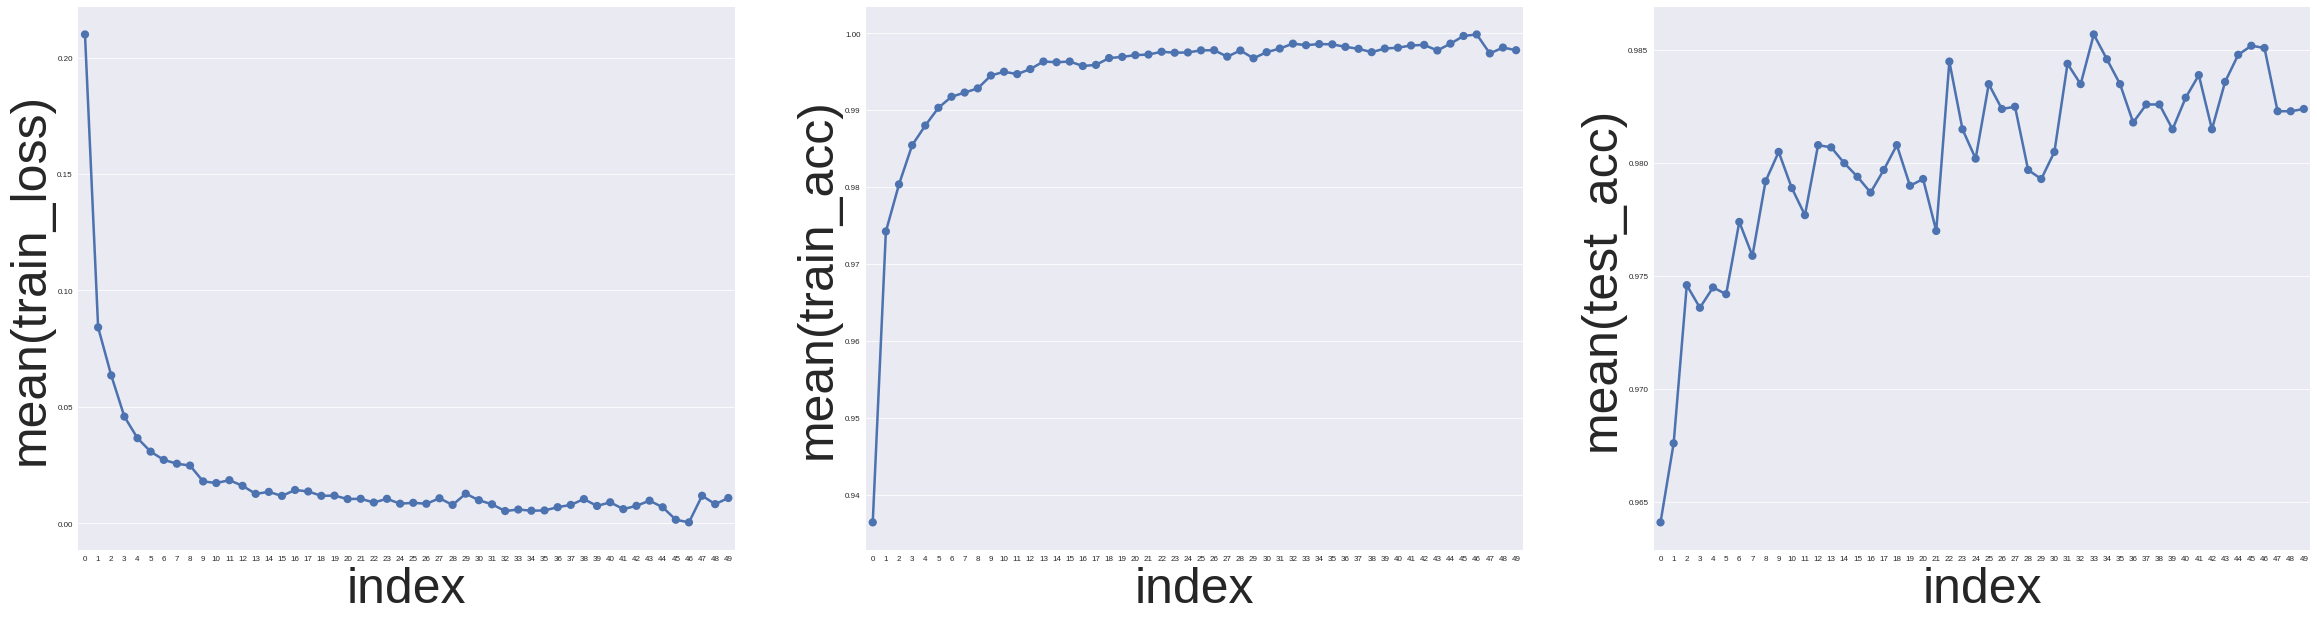

In [24]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
train_stats={}
train_stats['index']=[]
train_stats['train_loss']=[]
train_stats['test_acc']=[]
train_stats['train_acc']=[]

with tf.Session(config=tf.ConfigProto(log_device_placement=True),graph=nn_model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        train_stats['index'].append(i)
        ls=0
        train_correct=0
        train_total=0
        for batch in tqdm(train_batches):
            data,y=batch[:,:-1],batch[:,-1]
            y=y.astype(np.int32)
            l,_,p=sess.run([nn_model.loss,nn_model.opt,nn_model.probs],feed_dict={nn_model.x:data,nn_model.labels:y})
            train_correct+=check_equal(p,y)
            train_total+=y.shape[0]
            ls+=l
        
        ls=ls/len(train_batches)
        train_acc=float(train_correct)/float(train_total)
        train_stats['train_loss'].append(ls)
        train_stats['train_acc'].append(train_acc)
        
        test_correct=0
        test_total=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            p=sess.run(nn_model.probs,feed_dict={nn_model.x:data})
            test_correct+=check_equal(p,y)
            test_total+=y.shape[0]
        
        test_acc=float(test_correct)/float(test_total)
        train_stats['test_acc'].append(test_acc)
        print(str(i)+' loss:'+str(ls)+' train_acc:'+str(train_acc)+' test_acc:'+str(test_acc))
        
        nn_model.saver.save(sess,'model/model.pb') #save model 

train_df=pd.DataFrame(train_stats)
fig, axs = plt.subplots(ncols=3,figsize=(40,10))
ax1=sns.pointplot(x='index',y='train_loss',data=train_df,ax=axs[0])
ax2=sns.pointplot(x='index',y='train_acc',data=train_df,ax=axs[1])
ax3=sns.pointplot(x='index',y='test_acc',data=train_df,ax=axs[2])

In [15]:
!ls model

checkpoint		      model.pb.index  Train_Accuracy_Neuron_Pruning.png
model.pb.data-00000-of-00001  model.pb.meta


In [29]:
from google.colab import files
plt.savefig("./model/Train_Accuracy_Neuron_Pruning.png")

<Figure size 460.8x316.8 with 0 Axes>

INFO:tensorflow:Restoring parameters from model/model.pb


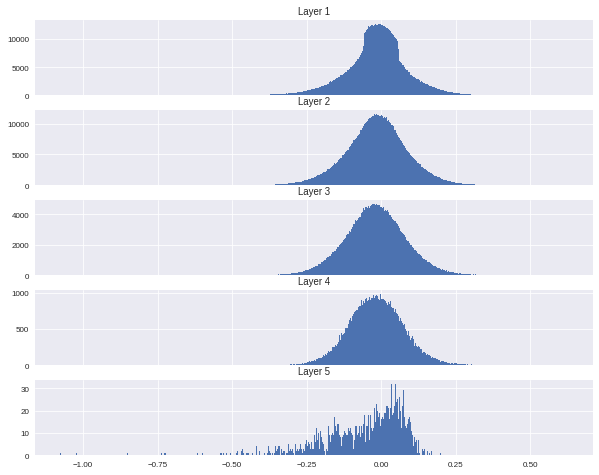

In [37]:
# Distribution Plot of weights
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
with tf.Session(config=config,graph=nn_model.graph) as sess:
    nn_model.saver.restore(sess,'model/model.pb')
    f,ax=plt.subplots(5,1,sharex=True,figsize=(10,8))
    for i, weights in enumerate(nn_model.trainable_vars):
        ax[i].hist(sess.run(weights).reshape(-1), bins=500)
        ax[i].set_title("Layer "+str(i+1))

In [38]:
plt.savefig("./model/plot_distribution.png")

<Figure size 460.8x316.8 with 0 Axes>

INFO:tensorflow:Restoring parameters from model/model.pb


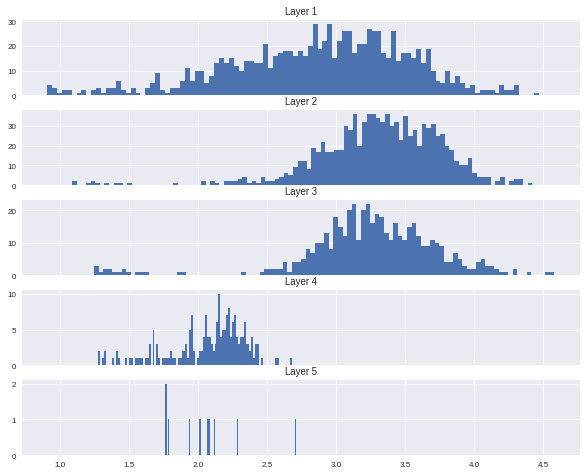

In [39]:
# Distribution plot of column norms for each weight

config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
with tf.Session(config=config,graph=nn_model.graph) as sess:
    nn_model.saver.restore(sess,'model/model.pb')
    f,ax=plt.subplots(5,1,sharex=True,figsize=(10,8))
    for i, weights in enumerate(nn_model.trainable_vars):
        weight_numpy=sess.run(weights)
        weight_numpy_norm=np.linalg.norm(weight_numpy,axis=0)
        ax[i].hist(weight_numpy_norm, bins=100)
        ax[i].set_title("Layer "+str(i+1))

In [40]:
plt.savefig("./model/plot_clm.png")

<Figure size 460.8x316.8 with 0 Axes>

In [0]:
k=[0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
tfe = tf.contrib.eager 

def compare_sparse_dense(eval_time_data,eval_data,p):
    """
    function to evaluate the pruned weights on the test set.
    comparing each of the evaluated pruned (zeroed out but dense) and sparsified weights and the timings 
    """
    
    time_sparse=time.clock()
    with tf.Session(config=config,graph=nn_model.graph) as sess:
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32) 
            sparseevaluate_func=tfe.py_func(nn_model.sparse_evaluate_eager,[x],tf.float32) # Wraps a python function into a TensorFlow operation that executes it eagerly
            
            # test set evaluation using sparsed weights
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]  
                preds_sparse=sess.run(sparseevaluate_func,feed_dict={x:data.T})
                test_correct+=check_equal(preds_sparse,y,axis=0)
                test_total+=y.shape[0]
                
                
    time_sparse=time.clock()-time_sparse
    test_acc_sparse=float(test_correct)/float(test_total)
    eval_time_data['time'].append(time_sparse)
    eval_time_data['category'].append('sparse')
    
    
    time_dense = time.clock()
    with tf.Session(config=config,graph=nn_model.graph) as sess:       
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32)
            denseevaluate_func=tfe.py_func(nn_model.dense_evaluate_eager,[x],tf.float32)
            
            #test set evaluation using dense weights (pruned)
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]
                preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})
                test_correct+=check_equal(preds_dense,y,axis=1)
                test_total+=y.shape[0]
    
            
    time_dense = time.clock()-time_dense
    test_acc_dense=float(test_correct)/float(test_total)
    assert test_acc_dense==test_acc_sparse
    eval_data['acc'].append(test_acc_dense)
    eval_time_data['time'].append(time_dense)
    eval_time_data['category'].append('dense')
    
    with tf.Session(config=config,graph=nn_model.graph) as sess:
        x=tf.placeholder(tf.float32)
        labels=tf.placeholder(tf.int32)
        logits=tf.placeholder(tf.float32)
        denseevaluate_func=tfe.py_func(nn_model.dense_evaluate_eager,[x],tf.float32)
        loss_func=tfe.py_func(nn_model.getloss,[logits,labels],tf.float32)
        # loss calculation for pruned weights on the test set
        test_ls=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})     
            ls=sess.run(loss_func,feed_dict={labels:y,logits:preds_dense})
            test_ls+=ls/len(eval_batches)
        eval_data['loss'].append(test_ls)
    print('k:'+str(p)+' test_acc:'+str(test_acc_dense)+' time_sparse:'+str(time_sparse)+ ' time_dense:'+str(time_dense)+' test_loss:'+str(test_ls))

INFO:tensorflow:Restoring parameters from model/model.pb
k:0 test_acc:0.9824 time_sparse:0.6306230000000141 time_dense:0.5142469999999548 test_loss:0.13789616038218214
INFO:tensorflow:Restoring parameters from model/model.pb
k:25 test_acc:0.9824 time_sparse:0.5919279999999958 time_dense:0.5034410000000094 test_loss:0.13664870826259282
INFO:tensorflow:Restoring parameters from model/model.pb
k:50 test_acc:0.9825 time_sparse:0.49979999999999336 time_dense:0.5048979999999688 test_loss:0.11798690199149077
INFO:tensorflow:Restoring parameters from model/model.pb
k:60 test_acc:0.9813 time_sparse:0.467158999999981 time_dense:0.5036539999999832 test_loss:0.10639131467353222
INFO:tensorflow:Restoring parameters from model/model.pb
k:70 test_acc:0.9783 time_sparse:0.4291820000000257 time_dense:0.5054319999999848 test_loss:0.09865104812609997
INFO:tensorflow:Restoring parameters from model/model.pb
k:80 test_acc:0.9726 time_sparse:0.38937799999996514 time_dense:0.5045780000000377 test_loss:0.1429

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


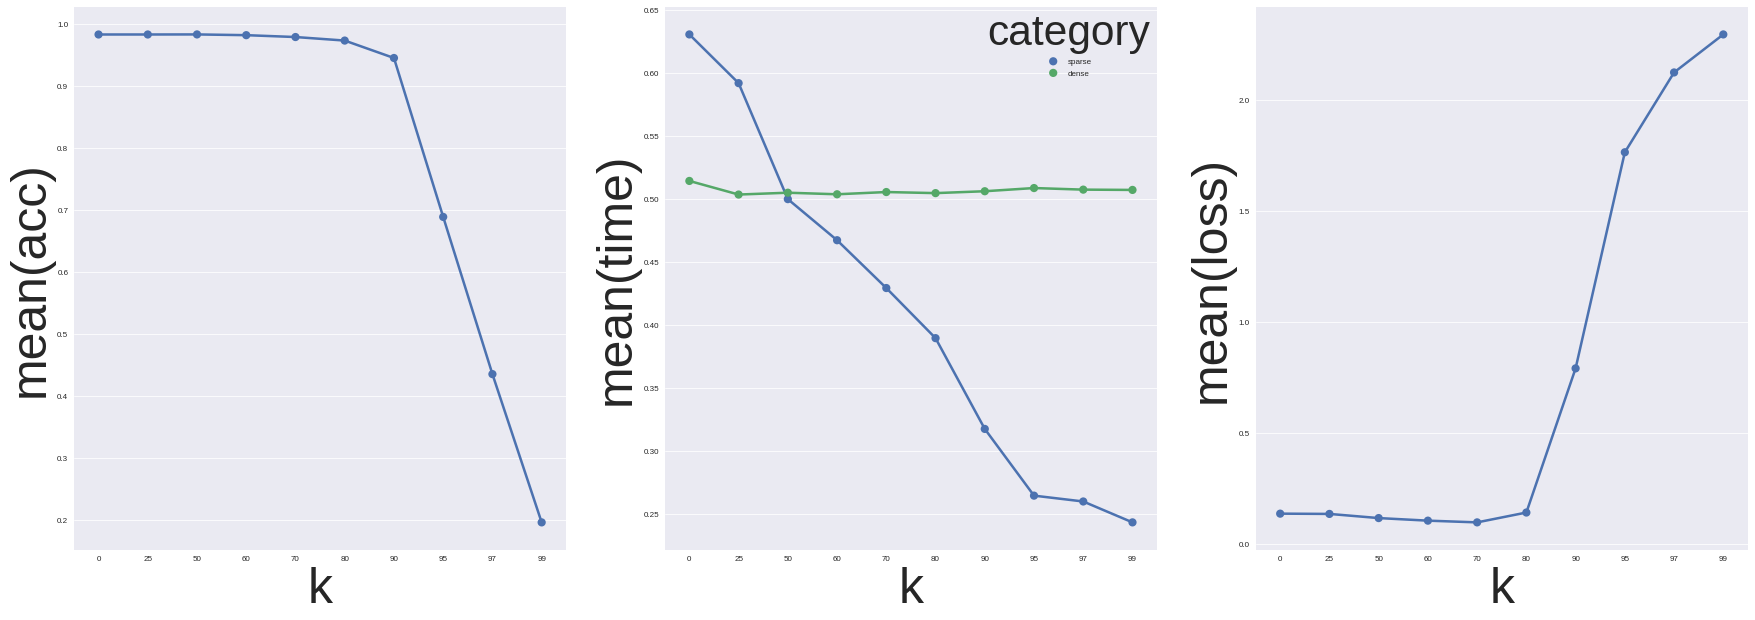

In [44]:
# Weight Pruning
# stats dictionary
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]

for p in k:  
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=nn_model.graph) as sess:
        nn_model.saver.restore(sess,'model/model.pb')
        nn_model.sparsified_weights=[]
        nn_model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        
        # each weight is pruned using the weight_prune_eager function defined in the nn_model
        weight_prune_func=tfe.py_func(nn_model.weight_prune_eager,[wt,percentile],[tf.float32])
        for v in nn_model.varstosparsify:
            w=sess.run(v)
            # get each weight to be pruned as numpy array and feed it into the eager function (weight_prune_eager) for pruning
            sp=sess.run(weight_prune_func,feed_dict={wt:w,percentile:p})
        last_layer=sess.run(nn_model.last_layer)
        nn_model.sparsified_weights.append(last_layer.T)
        nn_model.pruned_weights.append(last_layer)
    
    compare_sparse_dense(eval_time_data,eval_data,p)

eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))

ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])

In [45]:
plt.savefig("./model/weight_pruning_plot.png")

<Figure size 460.8x316.8 with 0 Axes>

INFO:tensorflow:Restoring parameters from model/model.pb
k:0 test_acc:0.9824 time_sparse:0.711892999999975 time_dense:0.516001000000017 test_loss:0.13789616038218214
INFO:tensorflow:Restoring parameters from model/model.pb
k:25 test_acc:0.9819 time_sparse:0.6015610000000038 time_dense:0.5076359999999909 test_loss:0.12022233865948846
INFO:tensorflow:Restoring parameters from model/model.pb
k:50 test_acc:0.9795 time_sparse:0.506781999999987 time_dense:0.5090089999999918 test_loss:0.09957459777051325
INFO:tensorflow:Restoring parameters from model/model.pb
k:60 test_acc:0.9778 time_sparse:0.47319100000004255 time_dense:0.501651000000038 test_loss:0.10865455088971916
INFO:tensorflow:Restoring parameters from model/model.pb
k:70 test_acc:0.8931 time_sparse:0.43763799999999264 time_dense:0.5083359999999857 test_loss:0.30711101485958586
INFO:tensorflow:Restoring parameters from model/model.pb
k:80 test_acc:0.8926 time_sparse:0.39188799999999446 time_dense:0.5068919999999935 test_loss:0.925475

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


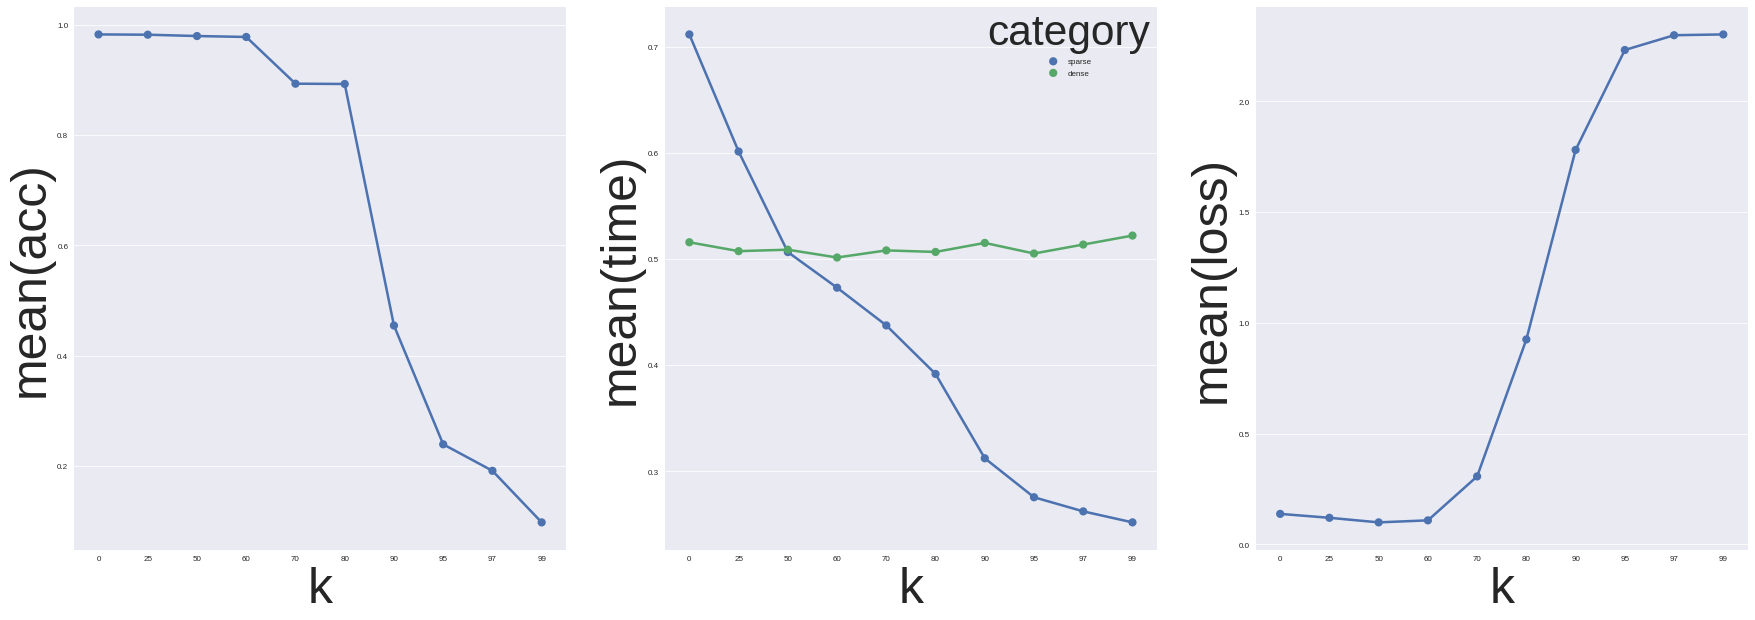

In [46]:
# Unit Pruning

# stats dictionary
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]
for p in k:
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=nn_model.graph) as sess:
        nn_model.saver.restore(sess,'model/model.pb')
        nn_model.sparsified_weights=[]
        nn_model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        unit_prune_func=tfe.py_func(nn_model.unit_prune_eager,[wt,percentile],[tf.float32])
        # each weight is pruned using the unit_prune_eager function defined in the nn_model
        for v in nn_model.varstosparsify:
            w=sess.run(v)
            # get each weight to be pruned as numpy array and feed it into the eager function (unit_prune_eager) for pruning
            sp=sess.run(unit_prune_func,feed_dict={wt:w,percentile:p})
        last_layer=sess.run(nn_model.last_layer)
        nn_model.sparsified_weights.append(last_layer.T)
        nn_model.pruned_weights.append(last_layer)
    
    compare_sparse_dense(eval_time_data,eval_data,p)
eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))

ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])

In [47]:
plt.savefig("./model/unit_pruning_plot.png")

<Figure size 460.8x316.8 with 0 Axes>